# Part 1: Exploratory Data Analysis

DataSource

    https://datarepo.eng.ucsd.edu/mcauley_group/data/beer/beeradvocate.json.gz

Important Attributes

    beer/ABV (numerical): alcohol by volume
    beer/beerID (numerical): beer ID
    beer/brewerID (numerical): brewer ID
    beer/name (categorical): name of beer
    beer/style (categorical): type/style of beer
    review/overall (numerical): overall beer rating out of 5
    review/appearance (numerical): beer rating based on appearance out of 5
    review/aroma (numerical): beer rating based on aroma out of 5
    review/palate (numerical): beer rating based on palate out of 5
    review/taste (numerical): beer rating based on taste out of 5
    review/text (text): beer review text
    review/time (UNIX time): date of review entry


Questions

    1. Will we use the entire dataset? If not, why?
    2. Why do we need sampling and how are we implementing it?
    3. What are the most popular styles of beer?
    4. What are the different types or classifications of beer available?
    5. Which beer has the best overall rating?
    6. The number of beers produced by each brewer
    7. What is the relationship between the beer's characteristics (appearance, aroma, palate, taste) and its overall rating?
    8. Sentiment analysis of beer reviews: How many are positive, negative, or neutral?
    9. Is there a correlation between the length or sentiment of the review text and the beer's overall rating?
    10. Can we predict the overall rating of a beer based on its characteristics and review?
    11. Temporal trends: How do beer reviews and ratings distribute over time?



In [ ]:
import numpy as np
import gzip
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from collections import defaultdict
import seaborn as sns
import random

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install gdown

## 1. Will we use the entire dataset? If not, why?

In [ ]:
!wget 'https://datarepo.eng.ucsd.edu/mcauley_group/data/beer/beeradvocate.json.gz'

--2023-12-05 13:43:05--  https://datarepo.eng.ucsd.edu/mcauley_group/data/beer/beeradvocate.json.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 453029619 (432M) [application/x-gzip]
Saving to: ‘beeradvocate.json.gz’

beeradvocate.json.g 100%[===================>] 432.04M  50.7MB/s    in 8.8s    

2023-12-05 13:43:15 (48.9 MB/s) - ‘beeradvocate.json.gz’ saved [453029619/453029619]



In [ ]:
z = gzip.open("beeradvocate.json.gz", "rt", encoding='utf8')
beeradvocate_dataset = []
for l in z:
    beeradvocate_dataset.append(eval(l))

In [ ]:
df = pd.DataFrame(beeradvocate_dataset)
df = df.sort_index(axis=1)

df.shape

(1586615, 13)

As we can see that size of the data is roughly 1500k, processing and training models on a dataset of such size extensive computational resources and leads to prolonged training times. To mitigate these challenges, we plan to downsize the dataset to 100,000 samples through sampling techniques provides a more practical approach. This reduction accelerates model development, conserves computational resources, and streamlines the workflow while maintaining essential data patterns.

## 2. Why do we need sampling and how are we implementing it?

Given the original dataset's massive size of 1,586,615 samples, training machine learning models on it would be computationally intensive and time-consuming. Therefore, we're implementing sampling to create a more manageable subset of the data.

In particular, we aim to maintain a balanced dataset, where each class or category is represented adequately. It ensures that for each group or category within the dataset, we sample a maximum of 50,000 samples or fewer if the group contains fewer than 50,000 samples. This approach helps us strike a balance between reducing the dataset's size, managing computational resources, and preserving class balance, ultimately enabling more efficient model development and training.

In [ ]:
df['review/overall'] = pd.to_numeric(df['review/overall'], errors='coerce')
df['review/appearance'] = pd.to_numeric(df['review/appearance'], errors='coerce')
df['review/aroma'] = pd.to_numeric(df['review/aroma'], errors='coerce')
df['review/palate'] = pd.to_numeric(df['review/palate'], errors='coerce')
df['review/taste'] = pd.to_numeric(df['review/taste'], errors='coerce')
df['beer/ABV'] = pd.to_numeric(df['beer/ABV'], errors='coerce')

# Handle any NaN values that might have been introduced by conversion
# You can choose to fill them with a default value or drop them
df = df.dropna(subset=['review/overall'])
df = df.dropna(subset=['review/appearance'])
df = df.dropna(subset=['review/aroma'])
df = df.dropna(subset=['review/palate'])
df = df.dropna(subset=['review/taste'])
df = df.dropna(subset=['beer/ABV'])
df = df.dropna(subset=['review/text'])


df['timestamp'] = pd.to_datetime(df['review/time'] , unit='s')
df['mon'] = df['timestamp'].dt.month
df['wday'] = df['timestamp'].dt.weekday  # Monday=0, Sunday=6
df['hour'] = df['timestamp'].dt.hour

# Convert 'review/overall' into a binary classification
df['binary_overall'] = (df['review/overall'] >= 4).astype(int)

In [ ]:
def parseData(fname):
    for l in open(fname):
        yield eval(l)

data = list(parseData("/content/drive/MyDrive/CSE 258-Assignment2/data100k_new.json"))[0]

In [ ]:
df = pd.DataFrame(data[0])
df = df.sort_index(axis=1)

print(df.shape)

df['review/profileName'] = df['review\\/profileName']
df['review/overall'] = df['review\\/overall']
df['review/appearance'] = df['review\\/appearance']
df['review/aroma'] = df['review\\/aroma']
df['review/palate'] = df['review\\/palate']
df['review/taste'] = df['review\\/taste']
df['beer/ABV'] = df['beer\\/ABV']
df['review/text'] = df['review\\/text']
df['review/time'] = df['review\\/time']
df['beer/beerId'] = df['beer\\/beerId']
df['beer/brewerId'] = df['beer\\/brewerId']
df['beer/name'] = df['beer\\/name']
df['beer/style'] = df['beer\\/style']

df = df.drop(columns=['review\\/profileName'])
df = df.drop(columns=['review\\/overall'])
df = df.drop(columns=['review\\/appearance'])
df = df.drop(columns=['review\\/aroma'])
df = df.drop(columns=['review\\/palate'])
df = df.drop(columns=['review\\/taste'])
df = df.drop(columns=['beer\\/ABV'])
df = df.drop(columns=['review\\/text'])
df = df.drop(columns=['review\\/time'])
df = df.drop(columns=['beer\\/beerId'])
df = df.drop(columns=['beer\\/brewerId'])
df = df.drop(columns=['beer\\/name'])
df = df.drop(columns=['beer\\/style'])

(100000, 18)


In [ ]:
grouped = df.groupby('binary_overall', group_keys=False)

# Sample 25,000 records from each class
# Make sure each class has at least 25,000 records
df = grouped.apply(lambda x: x.sample(n=min(len(x), 50000)))

# Check the balance of the classes
print(df['binary_overall'].value_counts())

0    50000
1    50000
Name: binary_overall, dtype: int64


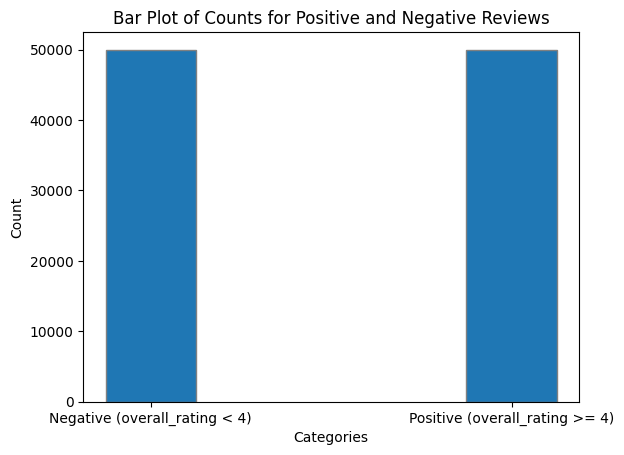

In [ ]:
# Histogram for Positive and Negative Overall Beer Ratings
condition = df['review/overall'] >= 4

# Calculate the number of entries satisfying the condition
count_positive = df[condition].shape[0]
count_negative = len(df) - count_positive

# Categories
categories = ['Negative (overall_rating < 4)', 'Positive (overall_rating >= 4)']

# Bar width
bar_width = 0.25

# Set the positions for the bars on X-axis
r1 = range(len(categories))
r1 = [x + bar_width/2 for x in r1]

# Plotting the bars
plt.bar(r1, [count_negative, count_positive], width=bar_width, edgecolor='grey', label='Negative Count')

plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Bar Plot of Counts for Positive and Negative Reviews')
plt.xticks([r + bar_width/2 for r in range(len(categories))], categories)

plt.show()

In [ ]:
df = df.sort_index(axis=1)

df.head().transpose()

,0,1,2,3,4
beer/ABV,8.0,11.8,11.5,10.0,5.2
beer/beerId,40200,1635,35754,63623,59
beer/brewerId,136,392,68,302,4
beer/name,Wasatch Devastator Double Bock,Quad,Double Dog Double Pale Ale,Dog Bite High Gravity Lager,Allagash White
beer/style,Doppelbock,Quadrupel (Quad),American Double \/ Imperial IPA,American Malt Liquor,Witbier
binary_overall,0,0,0,0,0
hour,1,0,1,16,17
mon,3,8,10,4,11
review/appearance,3.5,3.5,4.0,3.0,4.0
review/aroma,4.0,3.0,4.5,3.0,4.0


In [ ]:
cols = ['beer/ABV', 'beer/beerId', 'beer/brewerId', 'beer/name', 'beer/style',
        'review/overall', 'review/aroma', 'review/palate', 'review/taste',
        'review/appearance']
df[cols].describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
beer/ABV,100000.0,NaN,NaN,NaN,6.950525,2.327157,0.05,5.2,6.3,8.3,41.0
beer/beerId,100000,16576,412,193,NaN,NaN,NaN,NaN,NaN,NaN,NaN
beer/brewerId,100000,3055,35,2722,NaN,NaN,NaN,NaN,NaN,NaN,NaN
beer/name,100000,15668,India Pale Ale,197,NaN,NaN,NaN,NaN,NaN,NaN,NaN
beer/style,100000,104,American IPA,7226,NaN,NaN,NaN,NaN,NaN,NaN,NaN
review/overall,100000.0,NaN,NaN,NaN,3.665535,0.759418,0.0,3.5,3.75,4.0,5.0
review/aroma,100000.0,NaN,NaN,NaN,3.650565,0.727759,1.0,3.5,4.0,4.0,5.0
review/palate,100000.0,NaN,NaN,NaN,3.64753,0.710028,1.0,3.0,4.0,4.0,5.0
review/taste,100000.0,NaN,NaN,NaN,3.676055,0.770112,1.0,3.5,4.0,4.0,5.0
review/appearance,100000.0,NaN,NaN,NaN,3.783235,0.642763,0.0,3.5,4.0,4.0,5.0


In [ ]:
print(f"Total number of entries in the dataset {df.shape[0]}")
print(f"Number of Unique Beer IDs {df['beer/beerId'].nunique()}")
print(f"Number of Unique Brewer IDs {df['beer/brewerId'].nunique()}")
print(f"Number of Unique Beer names {df['beer/name'].nunique()}")
print(f"Number of Unique Beer styles {df['beer/style'].nunique()}")

Total number of entries in the dataset 100000
Number of Unique Beer IDs 16576
Number of Unique Brewer IDs 3055
Number of Unique Beer names 15668
Number of Unique Beer styles 104


## 3. What are the most popular styles of beer?

In [ ]:
# Checking the beer styles with highest overall ratings:
reviews = pd.DataFrame(df.groupby('beer/style')[['review/overall', 'review/aroma', 'review/palate', 'review/taste', 'review/appearance']].mean())
reviews['count_reviews'] = pd.DataFrame(df.groupby('beer/style')['review/overall'].count())
reviews.sort_values('count_reviews',ascending=False)[:5]

,review/overall,review/aroma,review/palate,review/taste,review/appearance,count_reviews
beer/style,,,,,,
American IPA,3.855037,3.837877,3.802173,3.836424,3.935026,7226
American Double \/ Imperial IPA,3.885225,4.048425,3.970687,4.014458,4.050307,5049
American Pale Ale (APA),3.724463,3.600838,3.611970,3.631613,3.745155,3818
Russian Imperial Stout,3.897972,4.013170,4.010596,4.047684,4.179080,3303
American Double \/ Imperial Stout,3.906656,4.104825,4.008819,4.089018,4.110649,3005


## 5. Which beer has the best overall rating?

In [ ]:
reviews.sort_values('review/overall',ascending=False)[:5]

,review/overall,review/aroma,review/palate,review/taste,review/appearance,count_reviews
beer/style,,,,,,
Gose,3.984375,3.750000,3.812500,3.937500,3.921875,32
Gueuze,3.955584,4.025381,3.964467,4.006345,3.975888,394
Lambic - Unblended,3.952055,4.116438,3.952055,4.075342,3.897260,73
Quadrupel (Quad),3.948034,4.079120,4.040730,4.122191,4.061330,1068
American Wild Ale,3.944008,4.063851,3.948919,4.054028,3.951375,1018


## 6. The number of beers produced by each brewer

<Figure size 2000x1000 with 0 Axes>

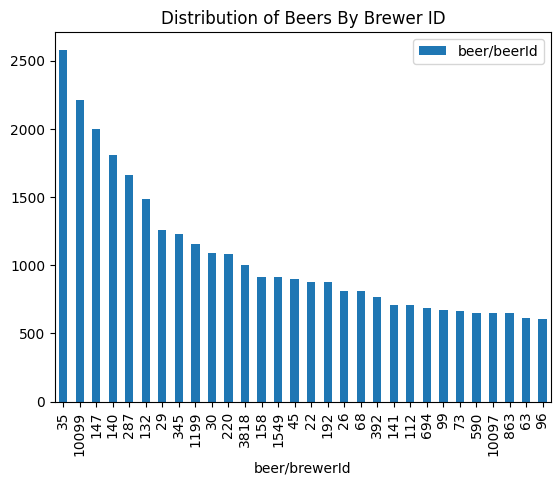

In [ ]:
brewers = pd.DataFrame(df.groupby('beer/brewerId')[['beer/beerId']].count())
brewers = brewers.sort_values(by='beer/beerId', ascending=False)
plt.figure(figsize=(20,10))
brewers.head(30).plot(kind='bar')
plt.title("Distribution of Beers By Brewer ID")
plt.show()

## 6. The Distribution of Overall Ratings of Beers:

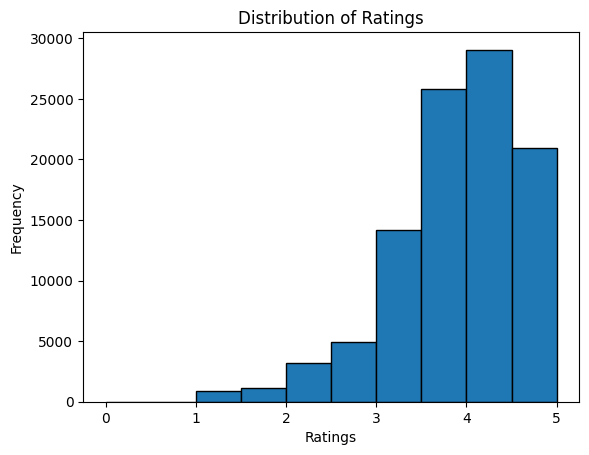

In [ ]:
ratings_column = df['review/overall']

# Plotting the histogram
plt.hist(ratings_column, bins=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5], edgecolor='black', width=0.5)

# Adding labels and title
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')

# Display the plot
plt.show()

## 11. Temporal trends: How do beer reviews and ratings distribute over time?

need to add why are we not choosing years

<Axes: xlabel='mon'>

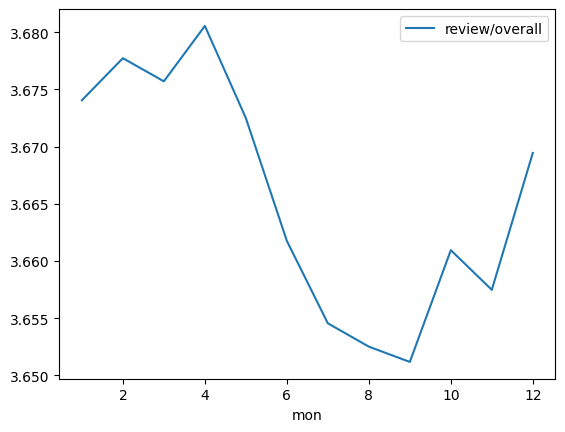

In [ ]:
month_avg = pd.DataFrame(df.groupby('mon')[['review/overall']].mean())
sns.lineplot(data=month_avg)

<Axes: xlabel='wday'>

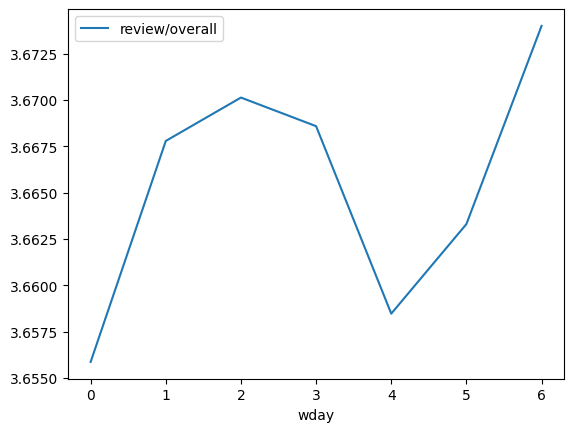

In [ ]:
wday_avg = pd.DataFrame(df.groupby('wday')[['review/overall']].mean())
sns.lineplot(data=wday_avg)

<Axes: xlabel='hour'>

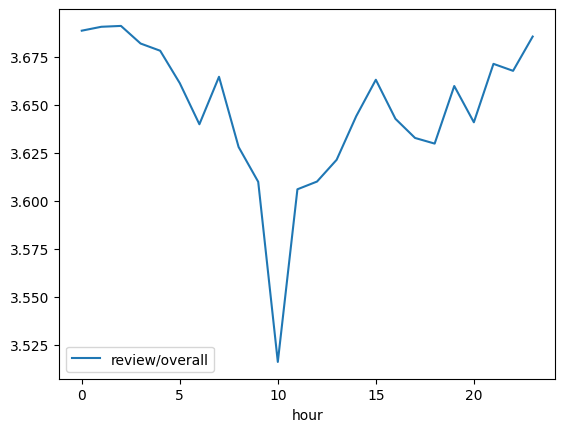

In [ ]:
hour_avg = pd.DataFrame(df.groupby('hour')[['review/overall']].mean())
sns.lineplot(data=hour_avg)

## 7. What is the relationship between the beer's characteristics (appearance, aroma, palate, taste) and its overall rating?

In [ ]:
corr_df = df[['review/overall', 'review/aroma', 'review/palate', 'review/taste', 'review/appearance']]
corr = corr_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,review/overall,review/aroma,review/palate,review/taste,review/appearance
review/overall,1.000000,0.630177,0.710764,0.800703,0.506093
review/aroma,0.630177,1.000000,0.625439,0.725960,0.573484
review/palate,0.710764,0.625439,1.000000,0.741765,0.571759
review/taste,0.800703,0.725960,0.741765,1.000000,0.549708
review/appearance,0.506093,0.573484,0.571759,0.549708,1.000000


## 8. Finding the Relative Standard Deviation of Overall Rating of Each Beer Style:

$\big($Relative Std of Beer Style's Overall Rating = $\frac{\text{Std. of Beer Style's Overall Rating}}{\text{Max. Standard Dev. (= 2.5)}}$$\big)$

In [ ]:
# Finding Standard Deviation of Overall Rating for each style of beer

beer_styles = sorted(list(set(df['beer/style'])))

In [ ]:
def add_relative_style_std(df):
    mean_ratings = df.groupby('beer/style')['review/overall'].mean().rename('mean_rating')
    df = df.merge(mean_ratings, on='beer/style')
    df['squared_diff'] = (df['review/overall'] - df['mean_rating'])**2
    sum_squared_diffs = df.groupby('beer/style')['squared_diff'].sum().rename('sum_squared_diff')
    counts = df.groupby('beer/style').size().rename('count')
    relative_std = (sum_squared_diffs / counts).apply(lambda x: (x**0.5) / 2.5).rename('relative_style_std')
    df = df.merge(relative_std, on='beer/style')
    return df.drop(['mean_rating', 'squared_diff'], axis=1, inplace=False)

df = add_relative_style_std(df)

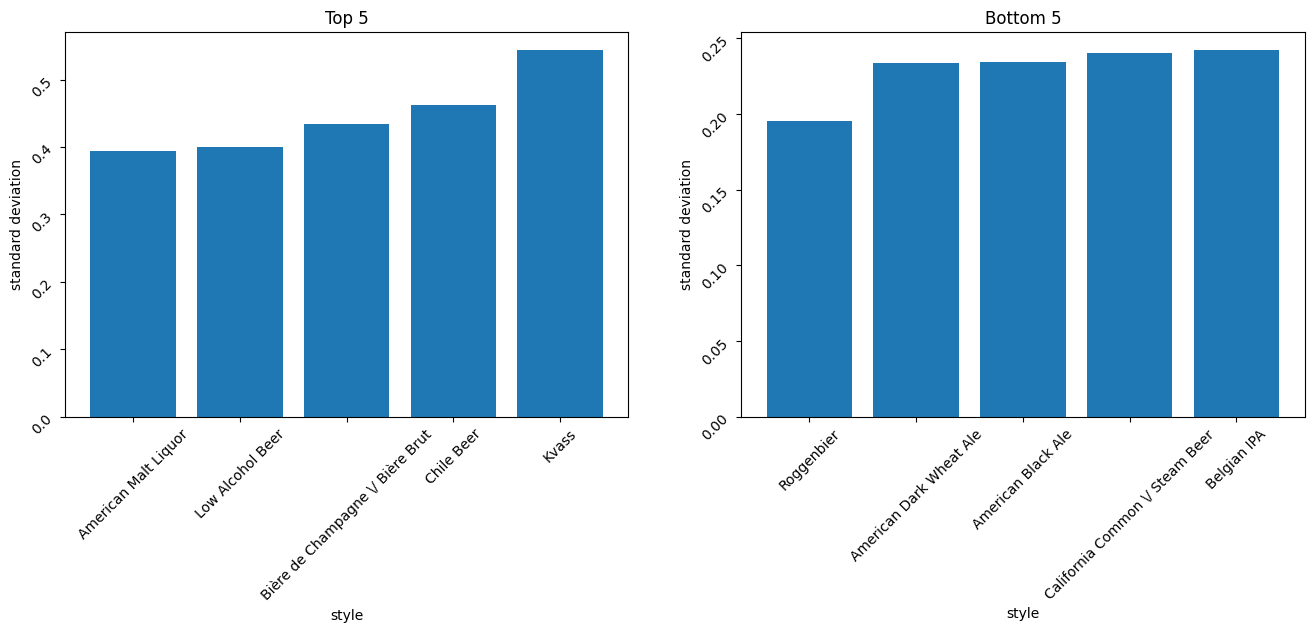

In [ ]:
from matplotlib import pyplot as plt
z = set()
for _,row in df.iterrows():
    z.add((row['beer/style'], row['relative_style_std']))
z_sorted = sorted(list(z), key = lambda x: x[1])
xtop = []
ytop = []
xbottom = []
ybottom = []
for style, std in z_sorted[-5:]:
    xtop.append(style)
    ytop.append(std)
for style, std in z_sorted[:5]:
    xbottom.append(style)
    ybottom.append(std)
fig,ax = plt.subplots(ncols=2, figsize = (16, 5))
ax[0].bar(xtop, ytop)
ax[0].set_xlabel('style')
ax[0].set_ylabel('standard deviation')
ax[0].tick_params(labelrotation=45)
ax[0].set_title('Top 5')
ax[1].bar(xbottom, ybottom)
ax[1].set_xlabel('style')
ax[1].set_ylabel('standard deviation')
ax[1].tick_params(labelrotation=45)
ax[1].set_title('Bottom 5')
plt.show()

## 8. Sentiment analysis of beer reviews: How many are positive, negative, or neutral?

In [ ]:
# from textblob import TextBlob

# def get_sentiment(text):
#     blob = TextBlob(text)
#     return blob.polarity

# def get_sentiment_label(text):
#     blob = TextBlob(text)
#     if blob.polarity > 0:
#         result = 'positive'
#     elif blob.polarity < 0:
#         result = 'negative'
#     else:
#         result = 'neutral'
#     return result


In [ ]:
# df['sentiment'] = df['review/text'].apply(get_sentiment)
# df['sentiment_label'] = df['review/text'].apply(get_sentiment_label)
# df[['review/text','sentiment','sentiment_label']]

,review/text,sentiment,sentiment_label
0,A lot of foam. But a lot.\tIn the smell some b...,-0.090909,negative
1,"Dark red color, light beige foam, average.\tIn...",0.147436,positive
2,"Almost totally black. Beige foam, quite compac...",0.338333,positive
3,"Golden yellow color. White, compact foam, quit...",0.362745,positive
4,"According to the website, the style for the Ca...",0.167143,positive
...,...,...,...
1586609,If you're looking for a quality beer right alo...,0.372771,positive
1586610,Growler fill from the long-awaited Defiant Bre...,0.322005,positive
1586611,This was served from a growler and I suspect a...,0.213713,positive
1586612,"Ah, the horseman commeth. Cloudy chocolate bro...",0.266880,positive


In [ ]:
# # How many positive and negative and neutral reviews?
# df['sentiment_label'].value_counts()


positive    1434385
negative      83580
neutral         864
Name: sentiment_label, dtype: int64

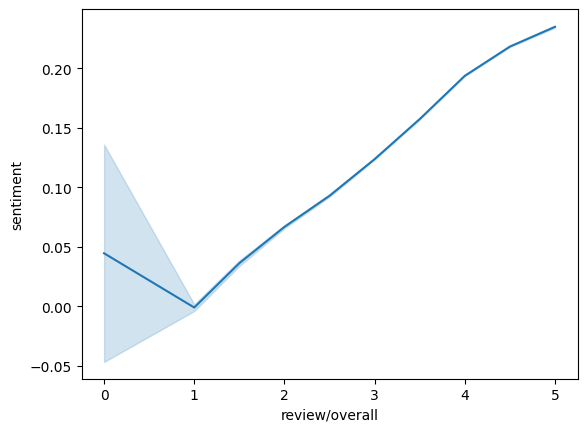

In [ ]:
sns.lineplot(data=df,x='review/overall',y='sentiment')
plt.show()

<Axes: xlabel='review/overall', ylabel='sentiment'>

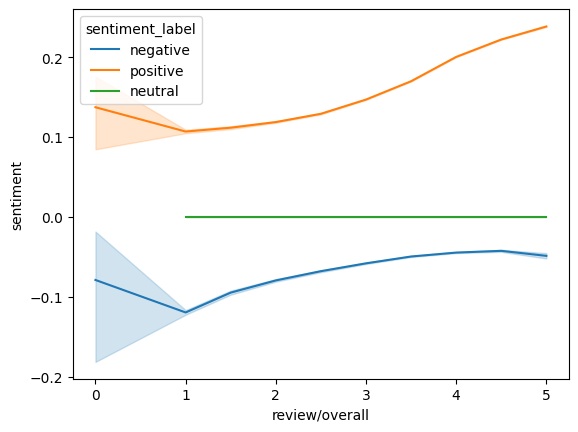

In [ ]:
sns.lineplot(data=df,x='review/overall',y='sentiment',hue='sentiment_label')

In [ ]:
# genuine_bad = df[(df['review/overall'] < 4) & (df['sentiment_label'] == 'negative')]
# genuine_good = df[(df['review/overall'] >= 4) & (df['sentiment_label'] == 'positive')]
# old_df = df
# df = pd.concat([genuine_bad, genuine_good])

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
dataset = df.to_dict('records')

In [ ]:
#!wget 'https://drive.google.com/file/d/1-3rqM1bqWrVcGERohlVF790WwEi_xmlQ/download?usp=drive_link'
!gdown 'https://drive.google.com/uc?id=1i0yXMzUzkn7zE8hLlyGSSYGcam3EWQAO'

Downloading...
From: https://drive.google.com/uc?id=1i0yXMzUzkn7zE8hLlyGSSYGcam3EWQAO
To: /content/data100k.csv
100% 105M/105M [00:00<00:00, 117MB/s] 


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/CSE 258-Assignment2/data100k_newest.csv", sep = ',')

dataset = df.to_dict(orient='records')

In [ ]:
df.to_csv('/content/drive/MyDrive/data_258/data100k_new.csv', index=False)
df.to_json('/content/drive/MyDrive/data_258/data100k_new.json', orient='records')

OSError: ignored

In [ ]:
print(dataset[0])

{'beer/ABV': 6.0, 'beer/beerId': 36986, 'beer/brewerId': 1457, 'beer/name': 'Arbor Brewing Brasserie Blonde Sparkling Ale', 'beer/style': 'Witbier', 'review/appearance': 3.0, 'review/aroma': 2.5, 'review/overall': 3.0, 'review/palate': 3.0, 'review/profileName': 'Shumista', 'review/taste': 3.5, 'review/text': "Poured a 12 oz. bottle into a pint glass.\t\tA- Pours a hazy golden orange with a one finger white head.\tS- Lots of fruit in the smell, especially citrus. \tT- Lots going on here. Some citrus, sour apple, wheat, and very sweet with a dry finish. \tM- Very carbonated, not too thin, not too thick.\tD- An interesting, different beer. I'm still deciding if I like it enough to buy it again, but I'm glad I gave it a try.", 'review/time': 1218422754, 'review/len': 413, 'timestamp': '2008-08-11 02:45:54', 'mon': 8, 'wday': 0, 'hour': 2, 'binary_overall': 0}


# Predictions:

In [ ]:
beerstyles = list(set([d['beer/style'] for d in dataset]))
num_beerstyles = len(beerstyles)

maxlen_rev =  max([len(d['review/text']) for d in dataset])

beerstyle_map = defaultdict()

index = 0
for style in beerstyles:
    beerstyle_map[style] = index
    index += 1

In [ ]:
dataset[0]

{'beer/ABV': 6.0,
 'beer/beerId': 36986,
 'beer/brewerId': 1457,
 'beer/name': 'Arbor Brewing Brasserie Blonde Sparkling Ale',
 'beer/style': 'Witbier',
 'review/appearance': 3.0,
 'review/aroma': 2.5,
 'review/overall': 3.0,
 'review/palate': 3.0,
 'review/profileName': 'Shumista',
 'review/taste': 3.5,
 'review/text': "Poured a 12 oz. bottle into a pint glass.\t\tA- Pours a hazy golden orange with a one finger white head.\tS- Lots of fruit in the smell, especially citrus. \tT- Lots going on here. Some citrus, sour apple, wheat, and very sweet with a dry finish. \tM- Very carbonated, not too thin, not too thick.\tD- An interesting, different beer. I'm still deciding if I like it enough to buy it again, but I'm glad I gave it a try.",
 'review/time': 1218422754,
 'review/len': 413,
 'timestamp': '2008-08-11 02:45:54',
 'mon': 8,
 'wday': 0,
 'hour': 2,
 'binary_overall': 0}

In [ ]:
from sklearn.model_selection import train_test_split

def feature4(datum):
    weekd_vec, month_vec, beerstyle_vec = [0]*6, [0]*11, [0]*num_beerstyles

    if(beerstyle_map[datum['beer/style']] > 0):
        beerstyle_vec[beerstyle_map[datum['beer/style']] - 1] = 1

    feature = [1, *beerstyle_vec, datum['beer/ABV'], datum['review/palate'], datum['review/taste'], datum['review/aroma'], datum['review/appearance'], len(datum['review/text'])/maxlen_rev]
    feat_list = np.array(feature, dtype=object)

    return feat_list

X = [feature4(d) for d in dataset]
y = [int(d['review/overall'] >= 4) for d in dataset]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y)

In [ ]:
def BER(y_test, y_pred):
  TP = 0
  TN = 0
  FP = 0

  for i in range(len(y_pred)):
      if(y_pred[i] and y_test[i]):
          TP += 1
      elif(not(y_pred[i]) and not(y_test[i])):
          TN += 1
      elif(y_pred[i] and not(y_test[i])):
          FP += 1

  FN = len(y_pred) - (TP + TN + FP)

  BER = 0.5 * ((FN/(FN + TP)) + (FP/(FP + TN)))

  print(BER)

In [ ]:
import xgboost as xgb

model = xgb.XGBClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

BER(np.array(y_test), y_pred)

0.1766


In [ ]:
import lightgbm as lgb

model = lgb.LGBMClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

BER(np.array(y_test), y_pred)

[LightGBM] [Info] Number of positive: 40000, number of negative: 40000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 107
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
0.17245


In [ ]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

base_classifier = LogisticRegression()
model = AdaBoostClassifier(base_classifier, n_estimators=100)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

BER(np.array(y_test), y_pred)

0.17665


In [ ]:
#Logistic Regression

model = LogisticRegression(max_iter = 1000)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

BER(np.array(y_test), y_pred)

0.17365000000000003


In [ ]:
#Random Forest Classifier

model = RandomForestClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

BER(np.array(y_test), y_pred)

0.19265


In [ ]:
#SVM Classifier

from sklearn import svm

model = svm.SVC()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

BER(np.array(y_test), y_pred)

0.17365


### Regression

In [ ]:
y = [d['review/overall'] for d in dataset]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
#Linear Regression

from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)

ypred = model.predict(X_test)

mse = (1/len(X_test)) * sum([(a - b)**2 for a,b in zip(ypred,y_test)])

print(mse)

0.1730253477409537


In [ ]:
!pip install mord

  Preparing metadata (setup.py) ... done
  Created wheel for mord: filename=mord-0.7-py3-none-any.whl size=9886 sha256=cad77c5cf25d812a239532e33403d6ce15905cdf59d8e75f1a05f84c5b4781a0
  Stored in directory: /root/.cache/pip/wheels/77/00/19/3cea86fbfc737ec4acb515cd94497dcc33f943fa157548b96c
Successfully built mord


In [ ]:
#Ordinal Regression

from mord import OrdinalRidge

model = OrdinalRidge().fit(np.array(X_train), np.array(y_train))

ypred = model.predict(np.array(X_test))

mse = (1/len(X_test)) * sum([(a - b)**2 for a,b in zip(ypred,y_test)])

print(mse)

0.2521875


In [ ]:
#RandomForestRegressor

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor().fit(np.array(X_train), np.array(y_train))

ypred = model.predict(np.array(X_test))

mse = (1/len(X_test)) * sum([(a - b)**2 for a,b in zip(ypred,y_test)])

print(mse)

0.192908603941543


In [ ]:
# MLP

from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

mlp_regressor = MLPRegressor()

# Define the parameter grid to search over
param_grid = {
    'hidden_layer_sizes': [(50, 25), (100, 50), (50, 50, 25)],
    'activation': ['relu'],
    'max_iter': [500],
}

# Create GridSearchCV instance
grid_search = GridSearchCV(mlp_regressor, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the best model
mse = (1/len(X_test)) * sum([(a - b)**2 for a,b in zip(ypred,y_test)])

print(mse)

Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (50, 25), 'max_iter': 500}
0.192908603941543


In [ ]:
pip install --upgrade scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 20.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
!gdown 'https://drive.google.com/uc?id=1Fd0l8JtAXOO1Ir8GPNcCJCRWSR7t1nsV'

Downloading...
From: https://drive.google.com/uc?id=1Fd0l8JtAXOO1Ir8GPNcCJCRWSR7t1nsV
To: /content/data100k_sentiment.json
100% 114M/114M [00:00<00:00, 126MB/s]


In [ ]:
f = open("data100k_sentiment.json")
dataset = []
for l in f:
    dataset.append(eval(l))
f.close()
dataset = dataset.squeeze(1)

In [ ]:
dataset[0]

In [ ]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from transformers import TFBertModel, BertTokenizer
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model

# Load your dataset (replace this with your actual data loading process)
X_text, X_other_features = np.array([d['review/text'] for d in dataset]),np.array([feature4(d) for d in dataset])

# Split the data into training and testing sets
X_text_train, X_text_test, X_other_train, X_other_test, y_train, y_test = train_test_split(
    X_text, X_other_features, y, test_size=0.2, random_state=42, stratify=y
)

# Tokenize the text data using a BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
X_text_train_encoded = tokenizer(list(X_text_train), padding=True, truncation=True, return_tensors="tf", max_length=128)
X_text_test_encoded = tokenizer(list(X_text_test), padding=True, truncation=True, return_tensors="tf", max_length=128)

# Load the BERT model
bert_model = TFBertModel.from_pretrained("bert-base-uncased", trainable=False)

# Create the text input layer
text_input = Input(shape=(128,), dtype=tf.int32, name="text_input")

# Generate text embeddings using BERT
text_embeddings = bert_model(text_input)[0][:, 0, :]

# Create the other features input layer
other_input = Input(shape=(X_other_train.shape[1],), name="other_input")

# Concatenate text embeddings with other features
concatenated_features = Concatenate()([text_embeddings, other_input])

# Add dropout for regularization
concatenated_features = Dropout(0.5)(concatenated_features)

# Create the output layer
output_layer = Dense(1, activation="sigmoid", name="output")(concatenated_features)

# Create the model
model = Model(inputs=[text_input, other_input], outputs=output_layer)

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Standardize the other features
scaler = StandardScaler()
X_other_train_scaled = scaler.fit_transform(X_other_train)
X_other_test_scaled = scaler.transform(X_other_test)

# Train the model
model.fit(
    [X_text_train_encoded["input_ids"], X_other_train_scaled],
    y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2
)

# Evaluate the model
y_pred = (model.predict([X_text_test_encoded["input_ids"], X_other_test_scaled]) > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

KeyboardInterrupt: ignored

In [ ]:
model = Model(inputs=[text_input, other_input], outputs=output_layer)

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model.fit(
    [X_text_train_encoded["input_ids"], X_other_train_scaled],
    np.array(y_train),
    epochs=5,
    batch_size=128,
    validation_split=0.2
)

# Evaluate the model
y_pred = (model.predict([X_text_test_encoded["input_ids"], X_other_test_scaled]) > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(np.array(y_test), y_pred))

# ber = 0.5 * (conf_matrix[0, 1] / (conf_matrix[0, 1] + conf_matrix[0, 0]) +
#              conf_matrix[1, 0] / (conf_matrix[1, 0] + conf_matrix[1, 1]))

# print("Binary Error Rate (BER):", ber)

(10000, 10)


0.22278505339282917


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import balanced_accuracy_score

# Assuming 'dataset' is a list of dictionaries as you've shown above.
df = pd.DataFrame(dataset)

# Normalize the review features by dividing by 5
review_features = ['review/palate', 'review/taste', 'review/aroma', 'review/appearance']
df[review_features] = df[review_features].apply(lambda x: x / 5)

# Add a new feature for the length of the review text
df['review/length'] = df['review/text'].apply(len)

# Update the features to include the new feature and normalized review features
features = ['beer/style', 'beer/ABV', *review_features, 'review/length']

# Define target variable
target = 'review/overall'

# Convert 'review/overall' into a binary classification problem
df[target] = (df[target] >= 4).astype(int)

# Create the feature matrix X and target vector y
X = df[features]
y = df[target]

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


ImportError: ignored

In [ ]:
# Preprocessing for numerical data: scaling
numeric_features = ['beer/ABV', 'review/palate', 'review/taste', 'review/aroma', 'review/appearance', 'review/length']
numeric_transformer = StandardScaler()

# Preprocessing for categorical data: one-hot encoding
categorical_features = ['beer/style']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [ ]:
# Create a MLPClassifier with a specified architecture
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=1000, random_state=42)

# Create a pipeline that combines the preprocessor with the MLP model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', mlp)])


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define a parameter grid to search over
param_grid = {
    'classifier__hidden_layer_sizes': [(50, 25), (100, 50), (150, 100)],
    'classifier__activation': ['relu'],
    'classifier__solver': ['adam'],
    'classifier__alpha': [0.001, 0.01],  # L2 penalty (regularization term) parameter
    'classifier__learning_rate_init': [0.01, 0.1],  # The initial learning rate
}

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='balanced_accuracy', verbose=1)

# Execute the grid search
grid_search.fit(X_train, y_train)

# Best parameters found
print(grid_search.best_params_)

# Use the best estimator to predict and evaluate the model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Recalculate BER
ber = balanced_accuracy_score(y_test, y_pred)
print(f'Improved Balanced Error Rate (BER): {ber}')


Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'classifier__activation': 'relu', 'classifier__alpha': 0.001, 'classifier__hidden_layer_sizes': (150, 100), 'classifier__learning_rate_init': 0.1, 'classifier__solver': 'adam'}
Improved Balanced Error Rate (BER): 0.8054606195060559


In [ ]:
# Train the MLP model
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['beer/ABV', 'review/palate',
                                                   'review/taste',
                                                   'review/aroma',
                                                   'review/appearance',
                                                   'review/length']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['beer/style'])])),
                ('classifier',
                 MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000,
                               random_state=42))])

In [ ]:
# Predict and evaluate the model
y_pred = pipeline.predict(X_test)

# Calculate Balanced Error Rate (BER)
ber = balanced_accuracy_score(y_test, y_pred)

print(f'Balanced Error Rate (BER): {ber}')


Balanced Error Rate (BER): 0.7672382071999475
